<a href="https://colab.research.google.com/github/erbisti/Collab/blob/main/Sparse_AE_MAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.3777 - val_loss: 0.2426
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.2346 - val_loss: 0.2109
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.2087 - val_loss: 0.1997
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.1982 - val_loss: 0.1862
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.1845 - val_loss: 0.1796
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.1787 - val_loss: 0.1720
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.1693 - val_loss: 0.1600
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.1591 - val_loss: 0.1516
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.1511 - val_loss: 0.1470
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.1466 - val_loss: 0.1431
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Esparsidade global (|z|<0.001): 0.751
Esparsidade por neurônio (primeiros 10): [1.    1. 

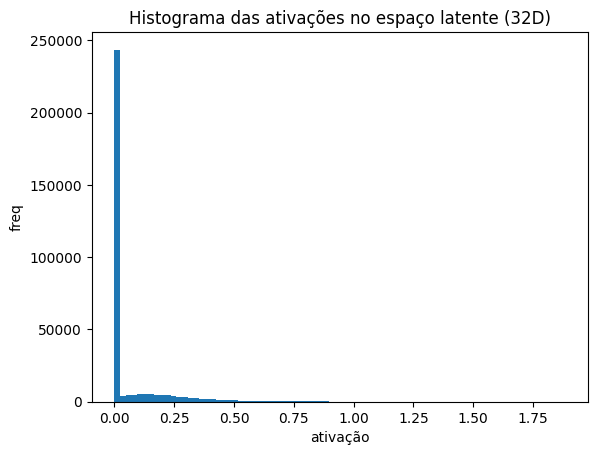

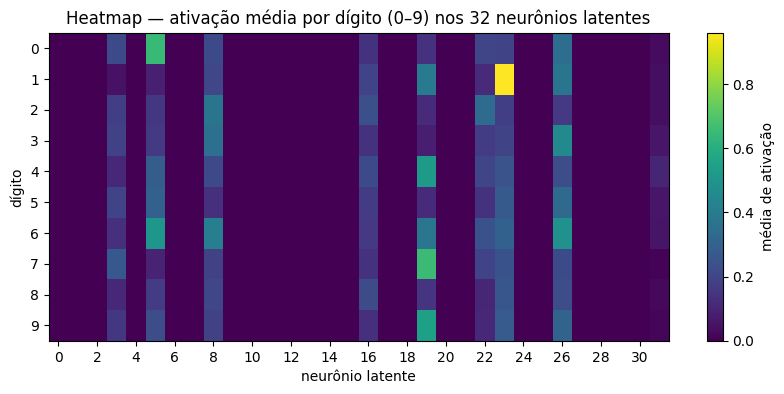

Neurônios 'mortos' (atividade média < 1e-4): [0, 1, 2, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 24, 25, 27, 28, 29, 30]
Top-8 neurônios mais ativos (por atividade média): [23, 19, 26, 5, 8, 22, 16, 3]
Atividades médias (top-8): [0.321142 0.312383 0.311858 0.256427 0.247719 0.18058  0.174906 0.15804 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


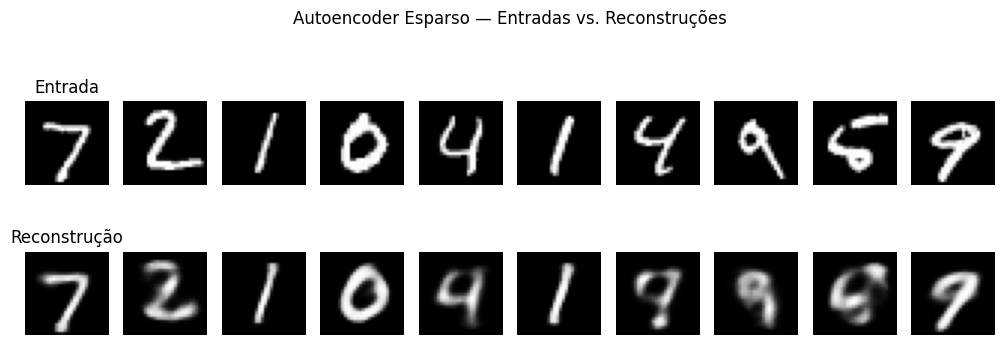

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


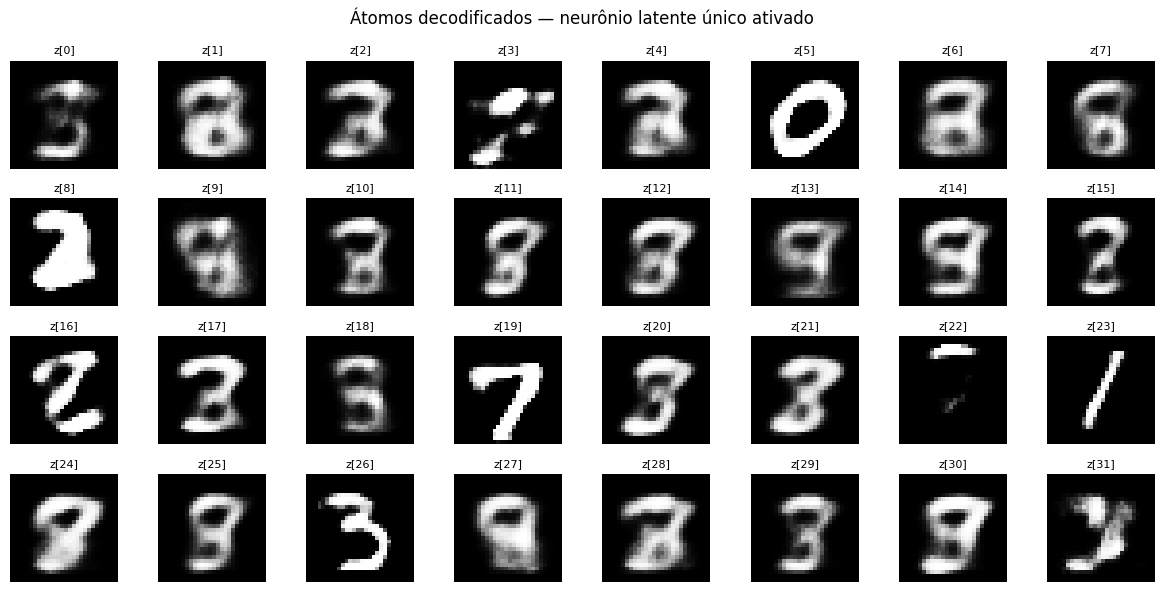

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt

# 1) Dados
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32")/255.).reshape(-1, 28*28)
x_test  = (x_test.astype("float32")/255.).reshape(-1, 28*28)

# 2) Modelo: AE com penalização L1 nas ATIVAÇÕES do bottleneck (sparse)
inp = layers.Input(shape=(784,))
h1  = layers.Dense(256, activation="relu")(inp)
h2  = layers.Dense(128, activation="relu")(h1)
z   = layers.Dense(32, activation="relu",
                   activity_regularizer=regularizers.L1(1e-5))(h2)  # <- esparsidade
d1  = layers.Dense(128, activation="relu")(z)
d2  = layers.Dense(256, activation="relu")(d1)
out = layers.Dense(784, activation="sigmoid")(d2)

autoenc = models.Model(inp, out, name="sparse_autoencoder")
autoenc.compile(optimizer="adam", loss="binary_crossentropy")
autoenc.fit(x_train, x_train, epochs=10, batch_size=256,
            shuffle=True, validation_data=(x_test, x_test), verbose=1)

# 3) Encoder para extrair o latente z
encoder = models.Model(inp, z)
Z = encoder.predict(x_test, batch_size=512)  # (N_test, 32)

# 4) Métricas simples de esparsidade
thr = 1e-3
frac_zeros_global = (np.abs(Z) < thr).mean()
frac_zeros_por_neuronio = (np.abs(Z) < thr).mean(axis=0)

print(f"Esparsidade global (|z|<{thr}): {frac_zeros_global:.3f}")
print("Esparsidade por neurônio (primeiros 10):",
      np.round(frac_zeros_por_neuronio[:10], 3))

# 5a) Histograma das ativações latentes (mostra concentração perto de 0)
plt.figure()
plt.hist(Z.flatten(), bins=80)
plt.title("Histograma das ativações no espaço latente (32D)")
plt.xlabel("ativação"); plt.ylabel("freq")
plt.show()

# 5b) Heatmap: média de ativação por dígito (10 x 32)
means_by_digit = np.zeros((10, Z.shape[1]))
for d in range(10):
    means_by_digit[d] = Z[y_test==d].mean(axis=0)

plt.figure(figsize=(10, 4))
plt.imshow(means_by_digit, aspect="auto")
plt.colorbar(label="média de ativação")
plt.yticks(range(10), [str(i) for i in range(10)])
plt.xticks(range(0, Z.shape[1], 2))
plt.title("Heatmap — ativação média por dígito (0–9) nos 32 neurônios latentes")
plt.xlabel("neurônio latente"); plt.ylabel("dígito")
plt.show()

# ========= ADIÇÕES

# 5c) Log extra de esparsidade: neurônios mortos e top-ativos
atividade_media = np.mean(np.abs(Z), axis=0)
neur_mortos = np.where(atividade_media < 1e-4)[0]
top_ativos = np.argsort(-atividade_media)[:8]
print("Neurônios 'mortos' (atividade média < 1e-4):", neur_mortos.tolist())
print("Top-8 neurônios mais ativos (por atividade média):", top_ativos.tolist())
print("Atividades médias (top-8):", np.round(atividade_media[top_ativos], 6))

# 6) Amostras: entrada vs. reconstrução (antes/depois)
recons = autoenc.predict(x_test[:10], batch_size=10)
plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray"); plt.axis("off")
    if i == 0: ax.set_title("Entrada")
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(recons[i].reshape(28, 28), cmap="gray"); plt.axis("off")
    if i == 0: ax.set_title("Reconstrução")
plt.suptitle("Autoencoder Esparso — Entradas vs. Reconstruções")
plt.tight_layout(); plt.show()

# 7) Imagens geradas por neurônio latente (1 ativado por vez)
# Reusa as camadas já criadas do decoder: são as 3 últimas do 'autoenc'
latent_in = tf.keras.Input(shape=(32,))
x_dec = autoenc.layers[-3](latent_in)  # Dense(128) após z
x_dec = autoenc.layers[-2](x_dec)      # Dense(256)
x_dec = autoenc.layers[-1](x_dec)      # Dense(784) sigmoide
decoder = models.Model(latent_in, x_dec)

latent_dim = Z.shape[1]  # 32
amp = 3.0                # ReLU exige valor positivo para ativar
E = np.zeros((latent_dim, latent_dim), dtype=np.float32)
for i in range(latent_dim):
    E[i, i] = amp

atoms = decoder.predict(E, batch_size=latent_dim)

cols = 8
rows = int(np.ceil(latent_dim/cols))
plt.figure(figsize=(12, 6))
for i in range(latent_dim):
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(atoms[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"z[{i}]", fontsize=8)
    plt.axis("off")
plt.suptitle("Átomos decodificados — neurônio latente único ativado")
plt.tight_layout(); plt.show()